# Keystroke Dynamics

Some explanation here

## Keylogger

We use a keyloger for the first step of the project, the Data Acquisition. In order to extrapolate useful results and metrics that we can use in for further analysis, two keyloggers need to run simultaniously: one that logs every time a button is pressed, and another that logs every time a button is released. Our keylogger saves separate files for pressed and released buttons. We save a new file every 10 seconds with the keys pressed/released during that interval, over a timespan of 1 minute.

In [1]:
# Imports
import keyboard # for keylogs
from threading import Timer
from datetime import datetime
import time
import sys

The logging parameters can be easily modified. In the current configuration, each keylogger saves a file every 10 seconds, over a total of 60 seconds. In the end, 12 files will be saved in two folders: 6 for pressed keys, 6 for released keys.

In [2]:
# Logging parameters
SEND_REPORT_EVERY = 10 # in seconds, 60 means 1 minute and so on
INTERRUPT_AFTER = 60 # in seconds, 60 means 1 minute and so on
start_time = time.time()

The keylogger works by triggering an event each time a button on the keyboard is pressed or released. The key is properly formatted with a timestamp of when it was pressed, and saved to a file. At the end of the SEND_REPORT_EVERY interval, the running text file is saved to the proper directory, and a new file is initialized. The keylogger exits at the end of the INTERRUPT_AFTER interval. When initializing the keylogger, the event type needs to be specified: "press" or "release".

In [3]:
# Keylogger
class Keylogger:
    def __init__(self, interval, report_method="file"):
        # we gonna pass SEND_REPORT_EVERY to interval
        self.interval = interval
        self.report_method = report_method
        # this is the string variable that contains the log of all 
        # the keystrokes within `self.interval`
        self.log = ""
        # record start & end datetimes
        self.start_dt = datetime.now()
        self.end_dt = datetime.now()
        
        self.event_type = ""
        self.user = ""

    def callback(self, event):
        """
        This callback is invoked whenever a keyboard event is occured
        (i.e when a key is released in this example)
        """
        name = event.name
        ts = time.time()
        timestamp = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S %f')
        if len(name) > 1:
            # not a character, special key (e.g ctrl, alt, etc.)
            # uppercase with []
            if name == "space":
                # " " instead of "space"
                name = "[space]"
            elif name == "enter":
                # add a new line whenever an ENTER is pressed
                name = "[enter]"
            elif name == "decimal":
                name = "."
            else:
                # replace spaces with underscores
                name = name.replace(" ", "_")
                name = f"[{name.upper()}]"
        # finally, add the key name to our global `self.log` variable
        self.log += "{} - {}\n".format(timestamp, name)
        # exit code if timer expired
        if time.time() - start_time > INTERRUPT_AFTER:
            sys.exit()

    def update_filename(self):
        # construct the filename to be identified by start & end datetimes
        start_dt_str = str(self.start_dt)[:-7].replace(" ", "-").replace(":", "")
        end_dt_str = str(self.end_dt)[:-7].replace(" ", "-").replace(":", "")
        self.filename = f"logs/{self.user}/{self.event_type}/keylog-{start_dt_str}_{end_dt_str}"

    def report_to_file(self):
        """This method creates a log file in the current directory that contains
        the current keylogs in the `self.log` variable"""
        # open the file in write mode (create it)
        with open(f"{self.filename}.txt", "w") as f:
            # write the keylogs to the file
            print(self.log, file=f)
        print(f"[+] Saved {self.filename}.txt")

    def report(self):
        """
        This function gets called every `self.interval`
        It basically sends keylogs and resets `self.log` variable
        """
        if self.log:
            # if there is something in log, report it
            self.end_dt = datetime.now()
            # update `self.filename`
            self.update_filename()
            if self.report_method == "file":
                self.report_to_file()
            # if you want to print in the console, uncomment below line
            # print(f"[{self.filename}] - {self.log}")
            self.start_dt = datetime.now()
        self.log = ""
        timer = Timer(interval=self.interval, function=self.report)
        # set the thread as daemon (dies when main thread die)
        timer.daemon = True
        # start the timer
        timer.start()

    def start(self, user, event):
        # record the start datetime
        self.start_dt = datetime.now()
        self.event_type = event
        self.user = user
        # start the keylogger
        if event == 'press':
            keyboard.on_press(callback=self.callback)
        if event == 'release':
            keyboard.on_release(callback=self.callback)
        # start reporting the keylogs
        self.report()
        # block the current thread, wait until CTRL+C is pressed
        keyboard.wait()

In [257]:
# Calling the keylogger
# user = "intruder"
# keylogger = Keylogger(interval=SEND_REPORT_EVERY, report_method="file")
# keylogger.start(user, "press")
# keylogger.start(user, "release")

## Preprocessing the logs for known users

The next step of our study is the preprocessing of data so we can easily study and exploit it for our further research. We need to take the textual data from the keylogger and transform it into data structures that are more efficient and usefult for the analysis that we plan to do.

In [1]:
# Imports
import glob
import pandas as pd
import sys
import math

from datetime import datetime

In [2]:
# Load dataframe 
intruder_dataframe = pd.DataFrame()
data = pd.read_csv('datasets/benchmark/DSL-StrongPasswordData.csv')
data.set_index(['subject', 'sessionIndex', 'rep'], inplace=True)

data_hold = data.filter(regex="H.").drop(columns=['H.period'])
data_hold = data_hold.stack().reset_index()[['subject', 0]]
intruder_dataframe['hold_time'] = data_hold[0] * math.pow(10, 6)
intruder_dataframe['user'] = data_hold['subject']

data_press_press = data.filter(regex="DD.")
intruder_dataframe['press_press_time'] = data_press_press.stack().reset_index()[0] * math.pow(10, 6)

data_press_release = data.filter(regex="UD.")
intruder_dataframe['press_release_time'] = data_press_release.stack().reset_index()[0] * math.pow(10, 6)

other_users = intruder_dataframe['user'].unique()

for user in other_users:
    user_data = intruder_dataframe[intruder_dataframe['user']==user]
    user_data.to_csv(f"datasets/intruders/{user}_data.csv", index=False)

Firtly, for each file in the key pressed and key released directories, we need to convert simple textual data into a useful data structure that is easy to manipulate. For our purposes, the ideal data structure is a DataFrame from Pandas.
A DataFrame is two-dimensional, size-mutable, potentially heterogeneous tabular data. This data structure also contains labeled axes (rows and columns). Arithmetic operations align on both row and column labels. It represents the primary pandas data structure.

Once out pressed and released data is properly formatted, we can merge them into a single file, detailing for each key when it was pressed and released in a single dataset. In order to do that firstly we remove any duplicated that might have occured when saving the separate text files. Then, for each timestamp of a released key, we search for the nearest timestamp for which the same key was pressed. We can then take that data and save it in a single dataset. We also identify in this dataset the name of the user who created this data, in order to properly differentiate between user datasets in our analysis.

Finally we measure a few key metrics and add them to our final dataset:
- press_press_time: a list of time intervals between different subsequent key presses.
- release_release_time: a list of time intervals between subsequent key releases.
- press_release_time: a list of time intervals that represent the time interval for which a key is released and the next key is pressed.
- hold_time: a list of time intervals that represent the time for which a certain key is pressed.

In [3]:
def preprocess(user=None):

    # Key-based

    press_files = glob.glob(f"logs/{user}/press/*.txt")
    press_rows = []

    release_files = glob.glob(f"logs/{user}/release/*.txt")
    release_rows = []

    for press_file in press_files:
        with open(press_file) as fp:
            line = fp.readline()
            while line:
                if line == "\n":
                    line = fp.readline()
                    continue
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                press_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    for release_file in release_files:
        with open(release_file) as fp:
            line = fp.readline()
            while line:
                if line == "\n":
                    line = fp.readline()
                    continue
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                release_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    press_df = pd.DataFrame(press_rows)
    release_df = pd.DataFrame(release_rows)

    # Map release -> press and build dataset
    dataset_rows = []
    for _, row in release_df.drop_duplicates(subset=['key']).iterrows():
        sub_df = release_df[release_df["key"] == row['key']]
        lower_bound = None
        for sub_id, sub_row in sub_df.reset_index().iterrows():
            higher_bound = sub_row["timestamp"]
            if sub_id == 0:
                press_time = press_df[(press_df["key"] == sub_row["key"]) & (
                    press_df["timestamp"] < higher_bound)].iloc[0]["timestamp"]
            else:
                press_time = press_df[(press_df["key"] == sub_row["key"]) & (
                    press_df["timestamp"] < higher_bound) & (press_df["timestamp"] > lower_bound)].iloc[0]["timestamp"]
            lower_bound = higher_bound
            dataset_rows.append({
                "key": sub_row["key"],
                "pressed": press_time,
                "released": sub_row["timestamp"],
                "user": user
            })

    dataset = pd.DataFrame(dataset_rows).sort_values(['pressed'])

    dataset["hold_time"] = (dataset["released"] -
                            dataset["pressed"]) / pd.Timedelta(microseconds=1)
    press_press_time = []
    press_release_time = []

    for index, row in dataset.reset_index().iterrows():
        press_press_delta = (dataset.iloc[index+1]["pressed"] -
                             dataset.iloc[index]["pressed"]) / pd.Timedelta(microseconds=1)
        press_press_time.append(press_press_delta)
        press_release_delta = (
            dataset.iloc[index+1]["pressed"] - dataset.iloc[index]["released"]) / pd.Timedelta(microseconds=1)
        press_release_time.append(press_release_delta)

        if index == len(dataset) - 2:
            press_press_time.append(0)
            press_release_time.append(0)
            break

    dataset["press_press_time"] = press_press_time
    dataset["press_release_time"] = press_release_time

    kb_dataset = dataset.copy().reset_index().drop(columns=['index']).drop(columns=['pressed', 'released', 'key'])
    kb_dataset.to_csv(f"datasets/key_based/{user}_data.csv", index=False)

    return kb_dataset

In [4]:
registered_users = ["alex", "stefan", "zihao", "zineb"]
for user in registered_users:
    preprocess(user)

## Statistical Analysis

This part of our code represents the second main task of the project: Data Exploration. We compute multiple different statistics using the generated and processed datasets. For our experimentation, each member of our team typed the same text using the keylogger, and a dataset was generated for each member. We then use them to compare different metrics and explore similarities and differences, as well as which metrics can help us identify a user just using keystroke dynamics.

In [5]:
# Imports
import pandas as pd
import glob
import json
import statistics

We compute several main statistics to start with, connected to our main metrics in the dataset:
- average_hold_time: average hold time
- average_press_press_time: average time between presses
- average_release_release_time: average time between releases
- average_press_release_time: average time between press and release of different keys
- apm: number of key presses per minute
- error_rate: error rate percentage (number of times backspace is pressed)

In [6]:
# Statistical analysis
def compute_statistics(dataset):
    average_hold_time = dataset["hold_time"].mean()
    average_press_press_time = dataset.iloc[:len(
        dataset)-1]["press_press_time"].mean()
    average_press_release_time = dataset.iloc[:len(
        dataset)-1]["press_release_time"].mean()
    values = list(dataset['press_press_time'].values)
    mean = sum(values)/len(values)
    apm = math.pow(10, 6) / mean
    ret = {
            "average_hold_time": average_hold_time,
            "average_press_press_time": average_press_press_time,
            "average_press_release_time": average_press_release_time,
            "user": dataset['user'][0],
            "apm": apm
        }
    return ret

In [140]:
# storing the statistics
def loadData():
    files = glob.glob(f"datasets/key_based/*.csv")
    rows = []
    dataframe = pd.DataFrame()
    for file in files:
        dataset = pd.read_csv(file)
        dataframe = dataframe.append(dataset)
        # Analyse statistique
        stats = compute_statistics(dataset)
        stats["user"] = dataset.iloc[0]["user"]
        rows.append(stats)
    return dataframe, pd.DataFrame(rows)

In [12]:
dataframe, statistics = loadData()

### Statistics visualisation

In [13]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import math

features = ['hold_time', 'press_press_time', 'press_release_time']

A Table view of the key statistical metrics for each user.

In [14]:
statistics

,average_hold_time,average_press_press_time,average_press_release_time,user,apm
0,274643.275064,196883.110825,-78105.520619,alex,5.092246
1,107527.354545,192648.159817,85190.452055,stefan,5.214512
2,133413.138756,236909.355769,103430.923077,zihao,4.241317
3,76886.756809,130400.771930,53523.996101,zineb,7.683615


BoxPlots for each metric for each user.

In [15]:
def boxPlotStats(dataframe):    
    fig, axs = plt.subplots(6, 2, figsize=(20, 10))
    fig.subplots_adjust(top=2, hspace=0.4)
    n=0
    for feature in features:
        for user in registered_users:
            axs[int(n/2), int(n%2)].text(.1,.9,user, horizontalalignment='left',transform=axs[int(n/2), int(n%2)].transAxes)
            axs[int(n/2), int(n%2)].boxplot(dataframe[dataframe['user']==user][feature])
            axs[int(n/2), int(n%2)].set_title(f"{feature} (microseconds)")
            n+=1
        

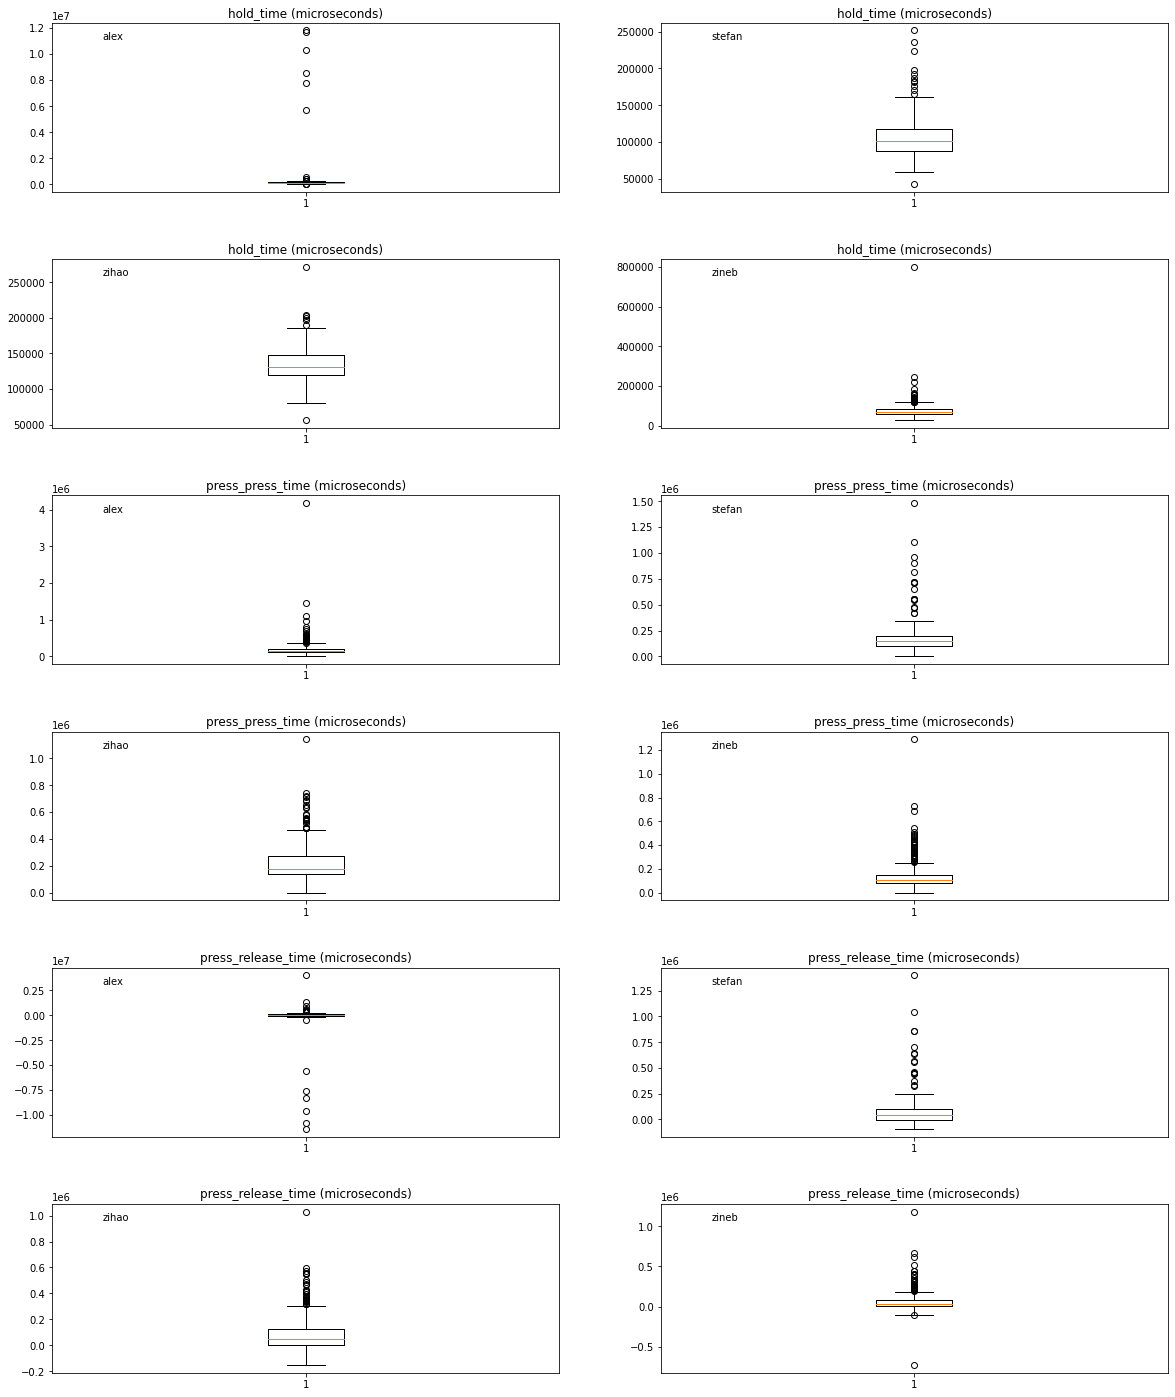

In [270]:
boxPlotStats(dataframe)

Plotting the distribution of different metrics over time for each user. The hold_time duration gives us interesting results, with distinct distibutions of durations for each users, which can help us separate when identifying the keystrokes of a certain user. The press_time metric is less interesting for example, with a fairly similar distribution for different users.

In [16]:
def barchartStats(dataframe):
    merged = dataframe.copy()

    # Rounding to closest milisecond
    for feature in features:
        merged[feature] = merged[feature].apply(lambda x: round(x/1000))
    fig, axs = plt.subplots(6, 2, figsize=(20, 10))
    fig.subplots_adjust(top=2, hspace=0.4)
    n=0
    for feature in features:
        for user in registered_users:
            mm = pd.DataFrame(merged[merged['user']==user].groupby(feature)[feature].count()).rename(columns={feature:'count'}).reset_index()
            axs[int(n/2), int(n%2)].bar(mm[feature], mm['count'])
            axs[int(n/2), int(n%2)].set_ylabel('count')
            axs[int(n/2), int(n%2)].set_xlabel('duration (ms)')
            axs[int(n/2), int(n%2)].set_title(f"{feature} - {user}")
            n+=1

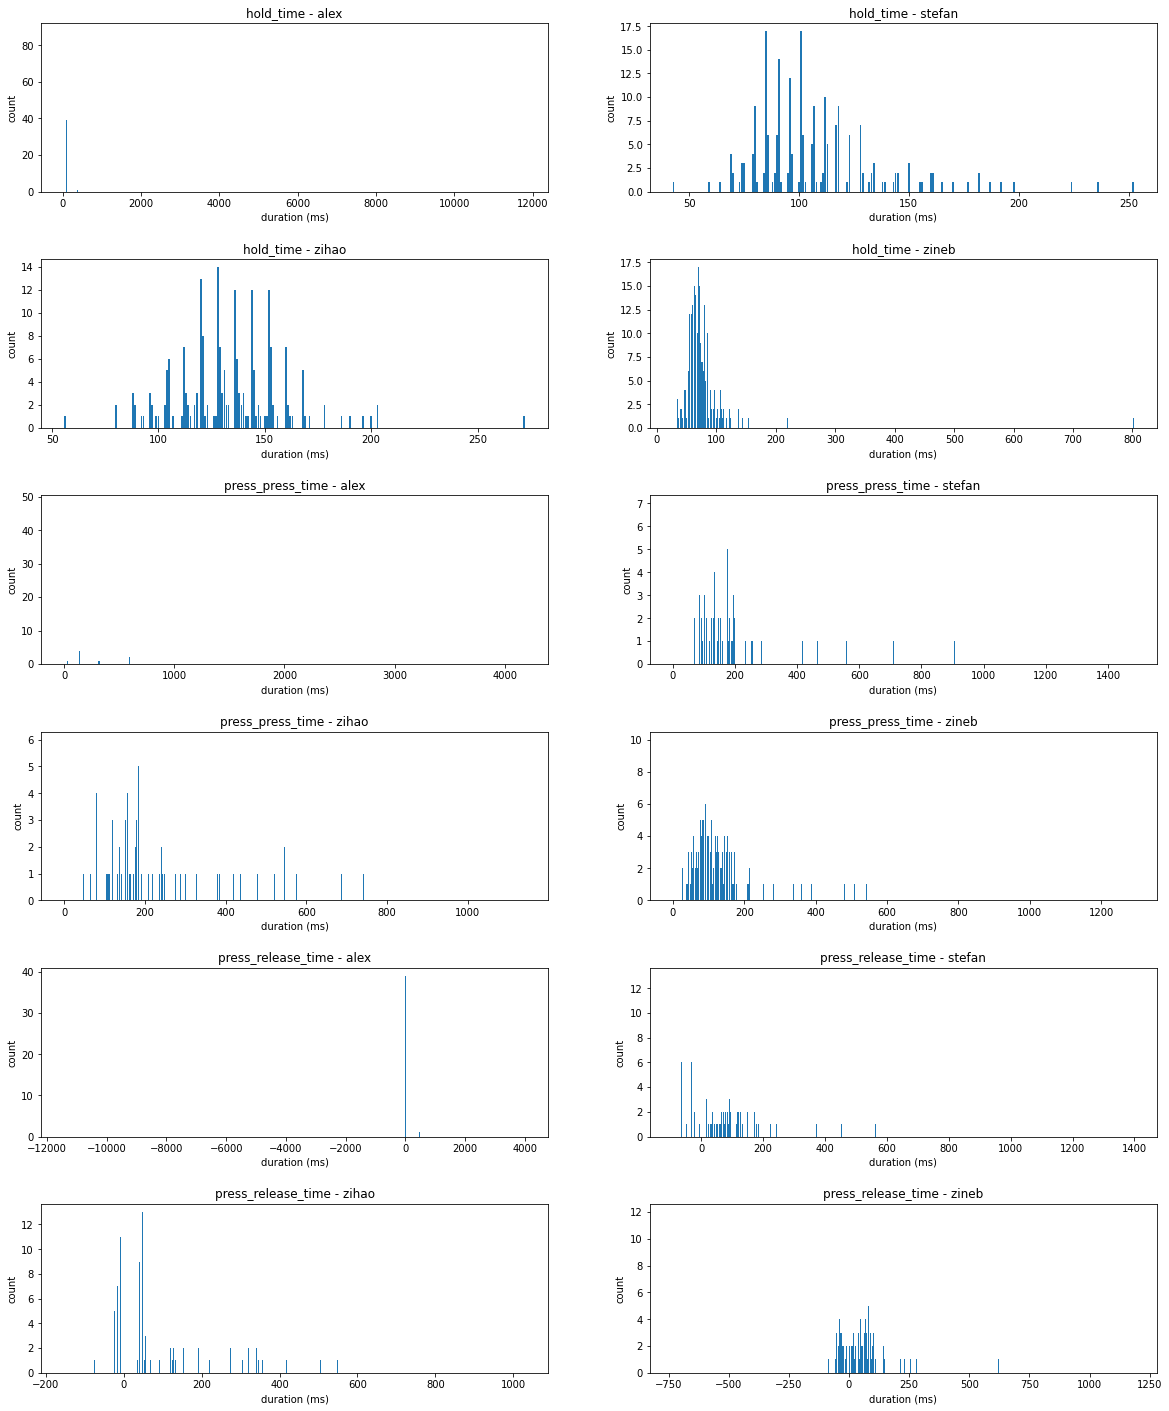

In [17]:
barchartStats(dataframe)

A Heatmap showing the correlation between different metrics. We can conclude that there is a big contrast between the hold_time and press_release_time, which means that there metrics can be contrasting and deciding factors to study when identifying a user. Metrics with a higher degree of correlation give us less information because of the similarity, such as the correlation between press_release_time and release_release_time.

In [19]:
# Correlation
def correlationPlot(dataframe):
    rcParams['figure.figsize'] = 10, 10
    fig = plt.figure()
    sns.heatmap(dataframe.corr(), annot=True, fmt=".2f")
    plt.show()

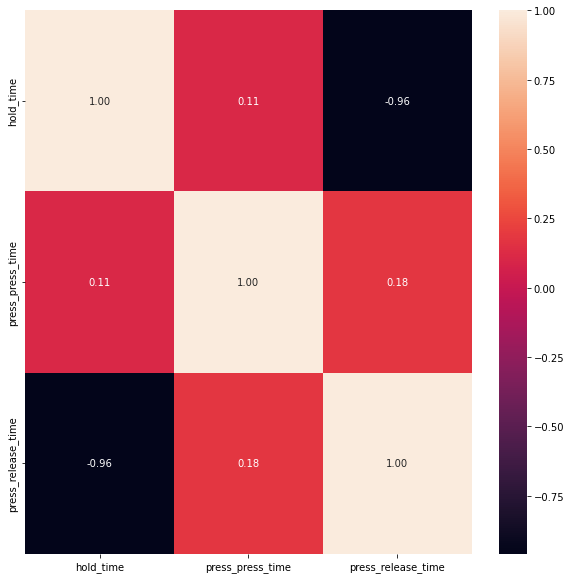

In [20]:
correlationPlot(dataframe)

For this graphic, for each metric and each user we calculate the value densities. This allows us to compare the typing styles between the different users efficiently, as we can see in the differences in densities for each user. This can allow us to study the possibility of identifying a user using keystroke dynamics. The hold_time density is especially interesting, with peaks that are significant in density and different for each user, making identification and classification easier to separate users.

In [21]:
def densityChartPlot(dataframe):    
    rcParams['figure.figsize'] = 15, 20

    # separate data based on users
    outcome_alex = dataframe[dataframe['user']=='alex'][features]
    outcome_stefan = dataframe[dataframe['user']=='stefan'][features]
    outcome_zihao = dataframe[dataframe['user']=='zihao'][features]
    outcome_zineb = dataframe[dataframe['user']=='zineb'][features]

    # init figure
    fig, axs = plt.subplots(3, 1)
    fig.suptitle('Features densities for users alex, stefan, zihao, zineb')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.4)

    colors = ['blue', 'red', 'orange', 'pink']
    # plot densities for outcomes
    i = 0
    for feature in features: 
        ax = axs[i]
        outcome_alex[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[0], legend=True,
                                    label=feature + ' for User = Alex')
        outcome_stefan[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[1], legend=True,
                                    label=feature + ' for User = Stefan')
        outcome_zihao[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[2], legend=True,
                                    label=feature + ' for User = Zihao')
        outcome_zineb[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[3], legend=True,
                                    label=feature + ' for User = Zineb')
        ax.set_xlabel(feature + ' values')
        ax.set_title(feature + ' density')
        ax.grid('on')
        ax.set_xlim(-600000, 600000)
        i+=1
    plt.show()

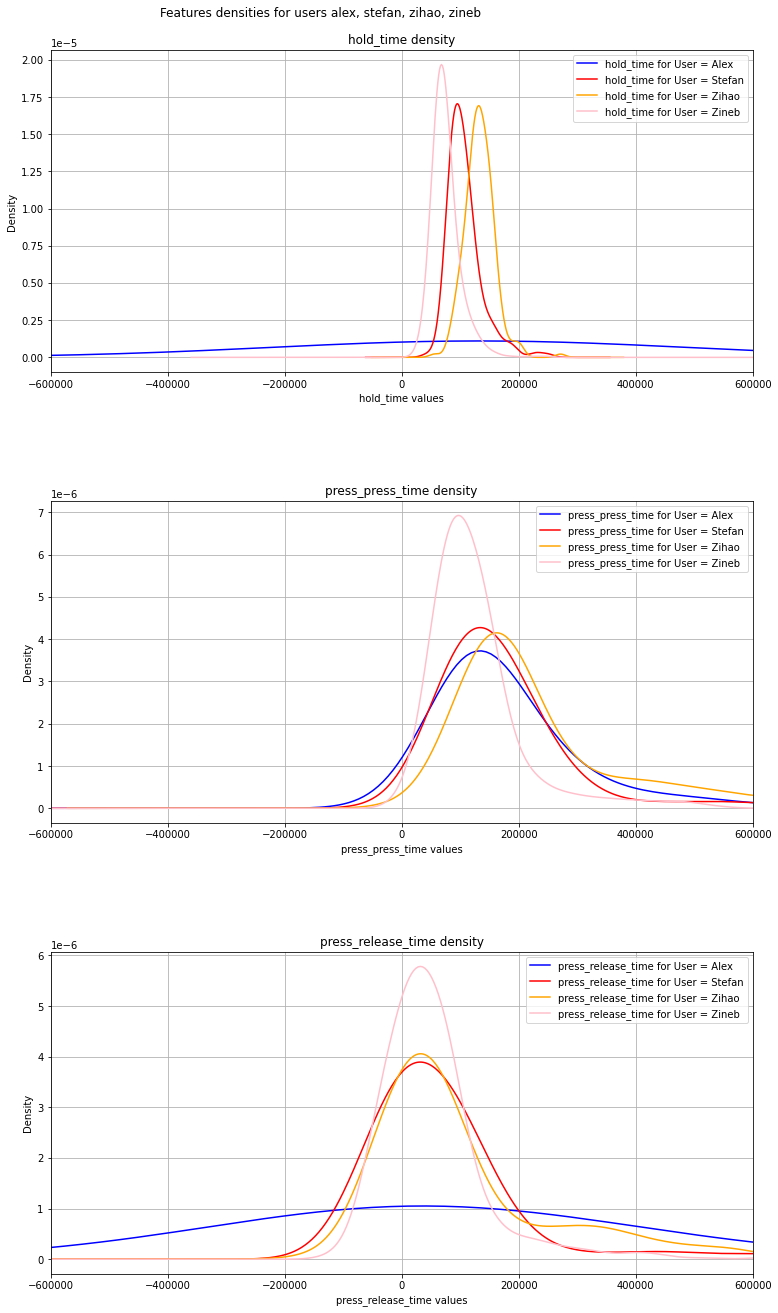

In [22]:
densityChartPlot(dataframe)

## Models


Some explanation here

## Cluster visualisation

In [39]:
def clusterVisualisation(dataframe):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.subplots_adjust(top=2, hspace=0.4)
    n=0
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            values = dataframe[[features[i], features[j], 'user']]
            col = values['user'].map({
                'alex': 'blue',
                'stefan': 'red',
                'zihao': 'orange',
                'zineb': 'pink'
            })
            values.plot.scatter(x=features[i], y=features[j], c=col, ax=axs[n])
            axs[n].set_ylabel(features[j])
            axs[n].set_xlabel(features[i])
            n+=1

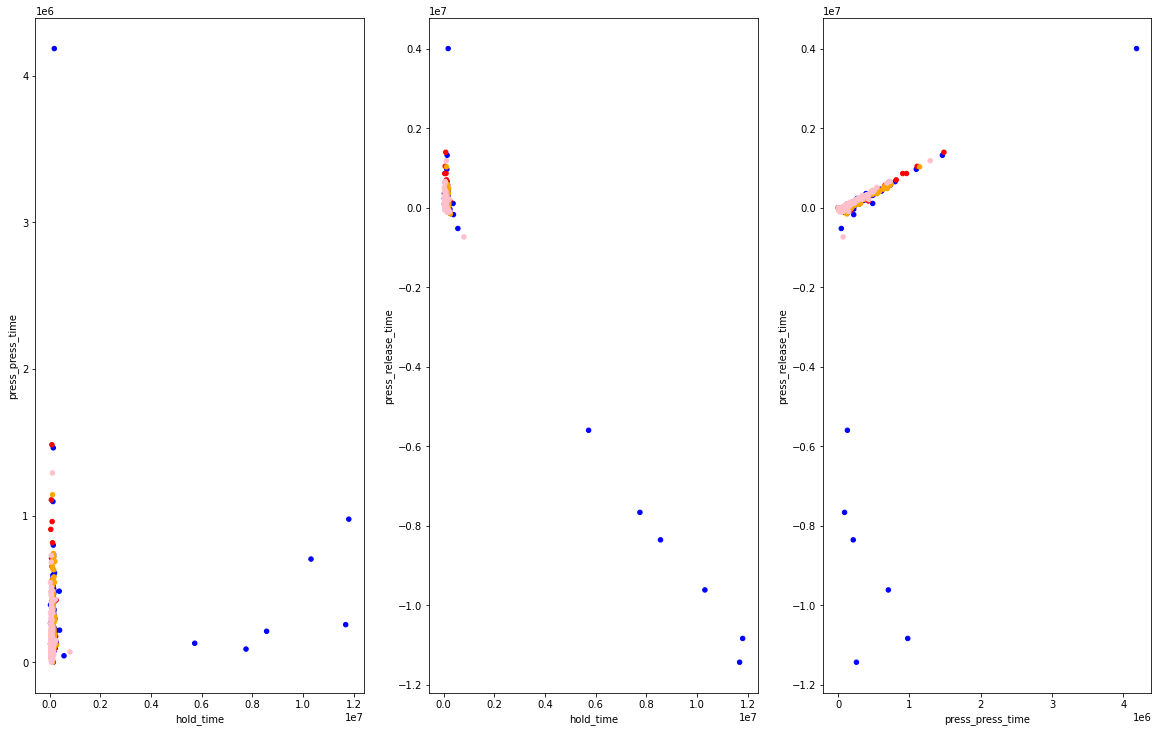

In [40]:
clusterVisualisation(dataframe)

## Models

In [69]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import Isomap

import pandas as pd
import glob
import math
import pickle
import json
import numpy as np

#### Model

The k-nearest neighbors algorithm (k-NN) is a non-parametric classification method. It is used for classification and regression. In our case, we use it for classification. The input consists of the k closest training examples in a data set, while the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [70]:
def getKNNData(dataframe):
    model_dataframe = dataframe.copy()
    X = model_dataframe[model_dataframe.columns.difference(
            ['user', 'pressed', 'released', 'key'])]

    lb_make = LabelEncoder()
    model_dataframe['user_code'] = lb_make.fit_transform(model_dataframe["user"])

    y = model_dataframe['user_code'].values

    model_dataframe = model_dataframe.drop(columns=['user'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scalerPickle = open(f'models/scalerpickle_file', 'wb')
    pickle.dump(scaler, scalerPickle)
    
    return X_train, X_test, y_train, y_test

In [71]:
def determineK(dataframe):
    X_train, X_test, y_train, y_test = getKNNData(dataframe)
    # Determine k
    error_rates = []
    x_values = np.arange(1, 45)
    for i in x_values:
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))

    plt.plot(x_values, error_rates)

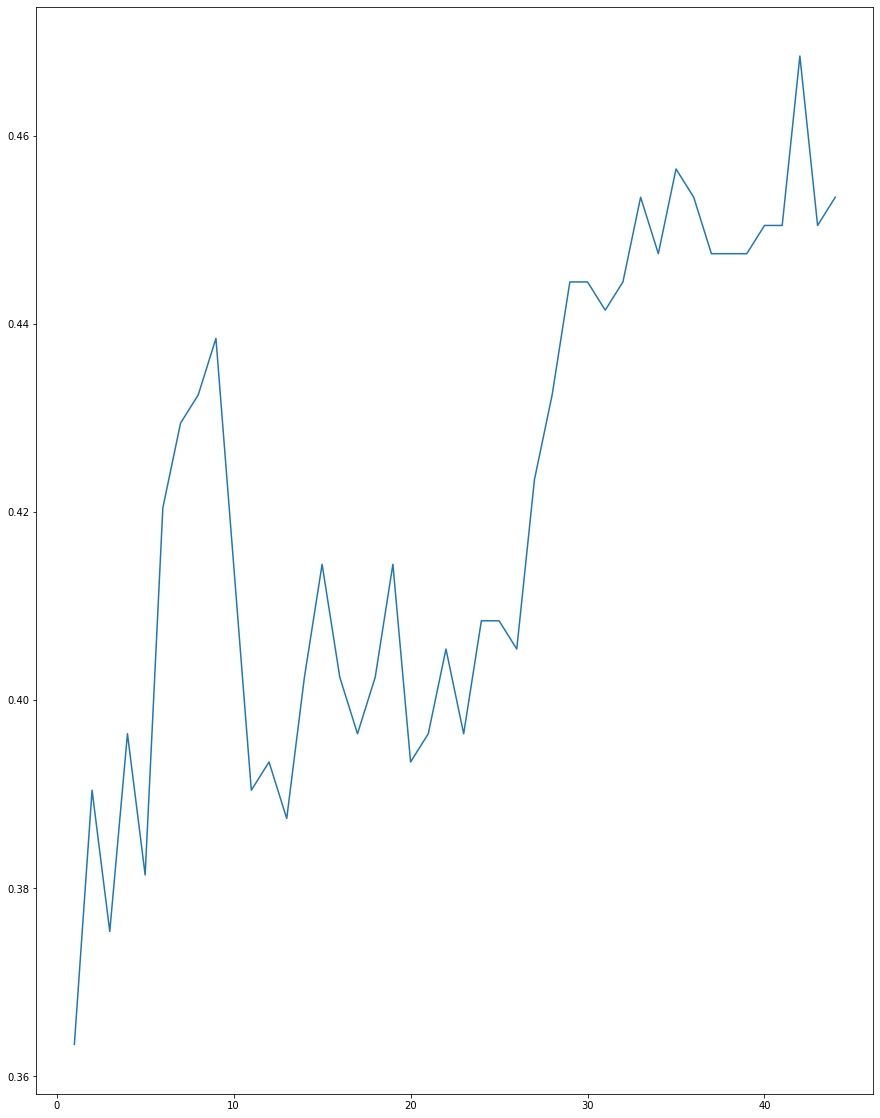

In [72]:
determineK(dataframe)

In [73]:
def buildAndTrainKNN(dataframe, k):
    X_train, X_test, y_train, y_test = getKNNData(dataframe)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the model on the training data.

    knn.fit(X_train, y_train)

    knnPickle = open(f'models/knnpickle_file', 'wb')
    pickle.dump(knn, knnPickle)

    print(knn.score(X_test, y_test))
    return X_train, y_train, X_test, y_test, knn

In [74]:
X_train, y_train, X_test, y_test, knn = buildAndTrainKNN(dataframe, 20)

0.6066066066066066


How do we determine K?
With a given K value, we determine the boundaries of each class. We determine the proper K to use by looking at the error rates produced by using different values of K. We then choose the value of K that producec the lowest error rate. In our case, that value is around the 7.5 mark.

The score output by the KNN algorithm represents the mean accuracy on a test dataset and given labels. We managed to achieve an accuracy rate of around 66.8%

#### Visualisation

In [75]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [76]:
def classificationReportKNN(knn, X_test, y_test):
    predictions = knn.predict(X_test)
    print(classification_report(y_test, predictions))
    print("----- Confusion Matrix ------")
    print(confusion_matrix(y_test, predictions))

In [77]:
classificationReportKNN(knn, X_test, y_test)

              precision    recall  f1-score   support

           0       0.53      0.64      0.58        99
           1       0.46      0.21      0.29        56
           2       0.47      0.43      0.45        49
           3       0.75      0.82      0.78       129

    accuracy                           0.61       333
   macro avg       0.55      0.53      0.52       333
weighted avg       0.59      0.61      0.59       333

----- Confusion Matrix ------
[[ 63   7  17  12]
 [ 18  12   4  22]
 [ 23   3  21   2]
 [ 16   4   3 106]]


## Gradient Boosting

Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error. Gradient boosting is used to minimize bias errors in the model. The cost function when this algorithm is used for classification is Log loss.

Gradient Boosting has allowed us to increase dramatically the accuracy of our model, going up to 83% accuracy of prediction.

In [78]:
def gradientBoosting(X_train, y_train, X_test, y_test):   
    gb = GradientBoostingClassifier(
            n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
    print(gb.score(X_test, y_test))
    gbPickle = open('models/gbpickle_file', 'wb')
    pickle.dump(gb, gbPickle)

In [79]:
gradientBoosting(X_train, y_train, X_test, y_test)

0.7987987987987988


# Recognition

We applied our models to a practical test to determine their efficiency and accuracy in detecting a user based on their typing. We load a model, and a file taken from our keylogger, and test to see which user the model will predict.

## KNN

The KNN model managed to predict Zineb's keystroke patterns with 85% of accuracy. On the below graph we see the percentages for all users. There is a significant margin of difference between the correct answer and the other users, which means that this model is accurate in correctly predicting a user.

In [98]:
def plotIdentificationKNN(knn_result):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.barh(registered_users, list(np.bincount(knn_result)))
    plt.show()

In [121]:
def identifyUserKNN(filePath, plot=True):
    # Load model
    loaded_knn = pickle.load(open('models/knnpickle_file', 'rb'))
    loaded_scaler = pickle.load(open('models/scalerpickle_file', 'rb'))

    # Load file
    dataframe_user = pd.read_csv(filePath)
    X = dataframe_user[dataframe_user.columns.difference(
        ['user', 'pressed', 'released', 'key'])]

    knn_result = loaded_knn.predict(loaded_scaler.transform(X))
    certainty = max(np.bincount(knn_result)) * 100 / sum(np.bincount(knn_result))
    print(certainty)
    if certainty > 65:
        print(filePath)
    if plot == True:
        plotIdentificationKNN(knn_result)

84.63035019455253


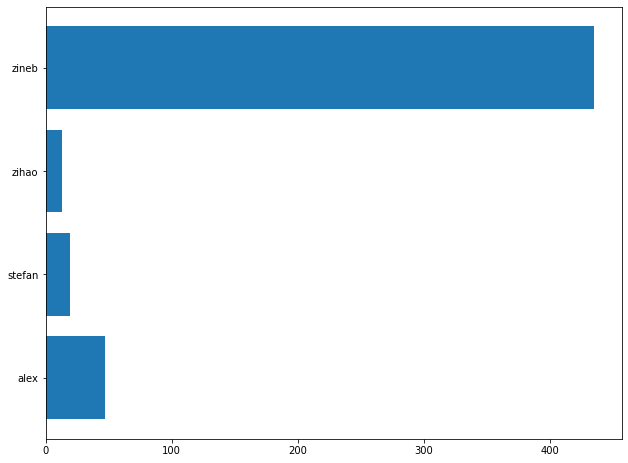

In [114]:
identifyUserKNN('datasets/key_based/zineb_data.csv')

40.15


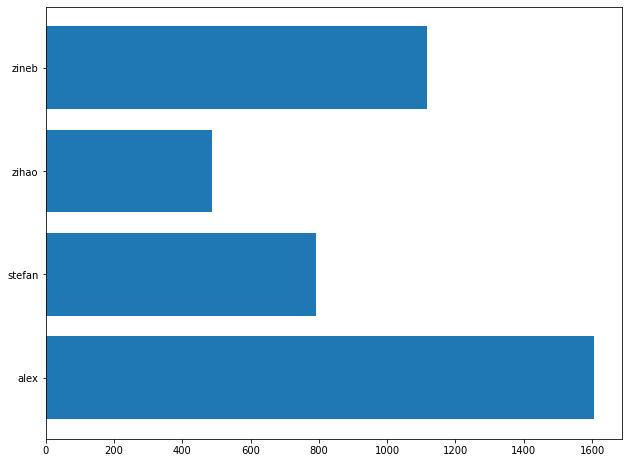

In [125]:
identifyUserKNN('datasets/intruders/s004_data.csv')

91.225
datasets/intruders/s017_data.csv


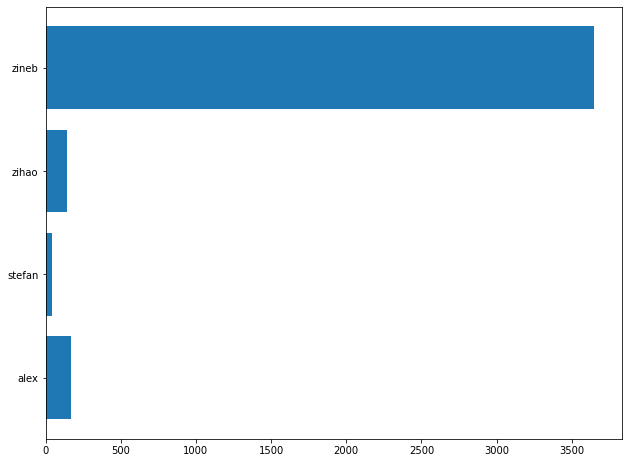

In [139]:
identifyUserKNN('datasets/intruders/s017_data.csv')

In [122]:
not_existing =[6, 9, 14, 23, 45, ]
for i in range(2, 58):
    number = f'00{i}' if i<10 else f'0{i}'
    if i not in not_existing:
        filePath = f'datasets/intruders/s{number}_data.csv'
        identifyUserKNN(filePath, False)

39.175
57.35
40.15
48.225
46.075
44.3
85.9
datasets/intruders/s010_data.csv
47.25
68.0
datasets/intruders/s012_data.csv
77.45
datasets/intruders/s013_data.csv
76.6
datasets/intruders/s015_data.csv
53.7
91.225
datasets/intruders/s017_data.csv
38.275
45.825
46.2
51.125
40.9
75.925
datasets/intruders/s024_data.csv
55.05
49.55
49.0
79.425
datasets/intruders/s028_data.csv
64.4
54.225
40.425
41.325
59.975
44.55
63.85
32.775
48.175
47.45
37.25
65.7
datasets/intruders/s040_data.csv
58.125
51.775
52.55
68.775
datasets/intruders/s044_data.csv
36.9
35.575
43.725
41.95
49.25
73.5
datasets/intruders/s051_data.csv
56.45
64.95
46.975
45.275
41.25
68.575
datasets/intruders/s057_data.csv


## Gradient Boosting

Using Gradient Boosting, the accuracy is dramatically increaced, with Zineb's typing being predicted with 93.7% certainty. On the below graph we see and even larger contrast between the users, which makes this model even more capable of predicting the correct user's typing patterns.

In [130]:
def plotIdentificationGB(gb_result):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.barh(registered_users, list(np.bincount(gb_result)))
    plt.show()

In [133]:
def identifyUserGB(filePath, plot=True):
    loaded_gb = pickle.load(open('models/gbpickle_file', 'rb'))
    loaded_scaler = pickle.load(open('models/scalerpickle_file', 'rb'))
    # Load file
    dataframe_user = pd.read_csv(filePath)
    X = dataframe_user[dataframe_user.columns.difference(
        ['user', 'pressed', 'released', 'key'])]
    
    gb_result = loaded_gb.predict(loaded_scaler.transform(X))
    certainty = max(np.bincount(gb_result)) * 100 / sum(np.bincount(gb_result))
    print(certainty)
    if certainty > 65:
        print(filePath)
    if plot == True:
        plotIdentificationGB(gb_result)

92.21789883268482


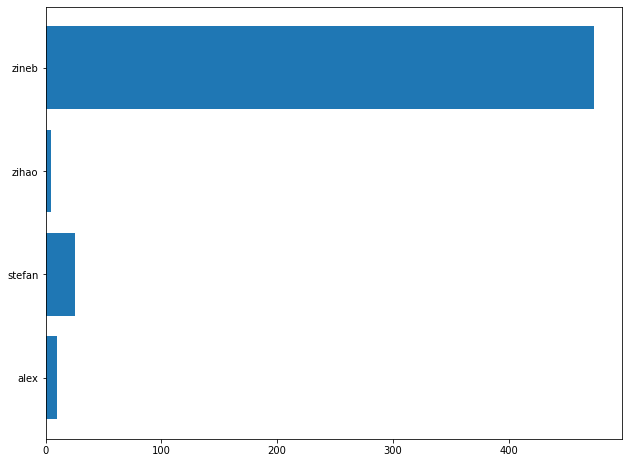

In [131]:
identifyUserGB('datasets/key_based/zineb_data.csv')

41.85


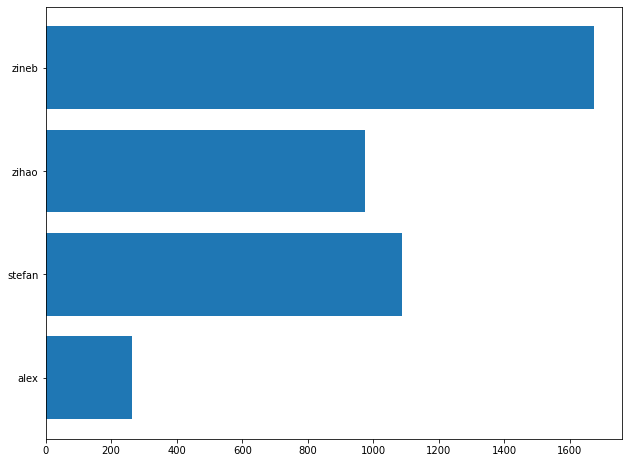

In [106]:
identifyUserGB('datasets/intruders/s004_data.csv')

98.65
datasets/intruders/s017_data.csv


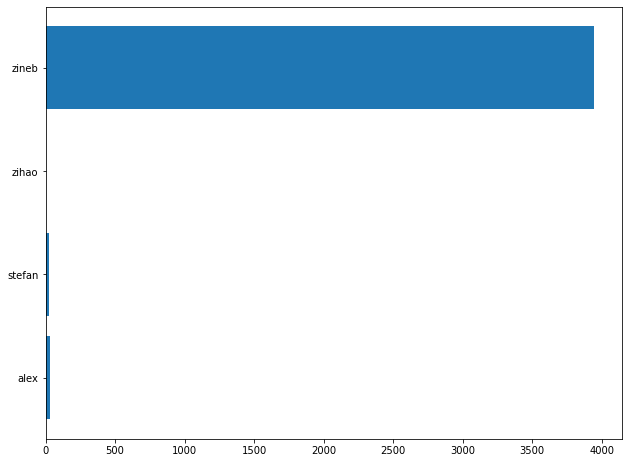

In [135]:
identifyUserGB('datasets/intruders/s017_data.csv')

In [134]:
not_existing =[6, 9, 14, 23, 45, ]
for i in range(2, 58):
    number = f'00{i}' if i<10 else f'0{i}'
    if i not in not_existing:
        filePath = f'datasets/intruders/s{number}_data.csv'
        identifyUserGB(filePath, False)

53.7
42.55
41.85
33.5
59.475
54.925
90.8
datasets/intruders/s010_data.csv
35.0
54.975
80.25
datasets/intruders/s013_data.csv
84.575
datasets/intruders/s015_data.csv
43.15
98.65
datasets/intruders/s017_data.csv
48.6
69.9
datasets/intruders/s019_data.csv
34.675
66.25
datasets/intruders/s021_data.csv
86.4
datasets/intruders/s022_data.csv
94.9
datasets/intruders/s024_data.csv
76.275
datasets/intruders/s025_data.csv
66.425
datasets/intruders/s026_data.csv
36.45
99.025
datasets/intruders/s028_data.csv
79.725
datasets/intruders/s029_data.csv
35.5
65.45
datasets/intruders/s031_data.csv
53.9
40.95
53.875
74.95
datasets/intruders/s035_data.csv
87.0
datasets/intruders/s036_data.csv
59.675
70.65
datasets/intruders/s038_data.csv
50.675
40.2
46.775
64.675
88.275
datasets/intruders/s043_data.csv
89.725
datasets/intruders/s044_data.csv
49.825
50.125
54.7
41.975
64.35
81.7
datasets/intruders/s051_data.csv
69.825
datasets/intruders/s052_data.csv
68.125
datasets/intruders/s053_data.csv
61.625
45.9
42.05
